# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

#df_raw = pd.read_feather('tmp/raw')
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,Low,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,High,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,High,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,Low,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,Medium,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20598236351024357, 0.24821199603130545, 0.9113262857029069, 0.8899744601761164, 0.894281403051316]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.24 s, sys: 7.25 ms, total: 1.25 s
Wall time: 1.29 s


(9.263026522794197, 0.319854941321508)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [11]:
??parallel_trees

#def parallel_trees(m, fn, n_jobs=8):
#        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 63.9 ms, sys: 64 ms, total: 128 ms
Wall time: 868 ms


(9.263026522794197, 0.319854941321508)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

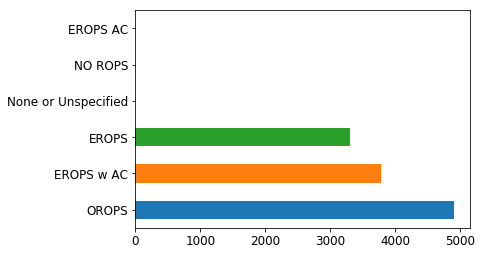

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841148,0.278901
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574973,0.260966
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683403,0.223766


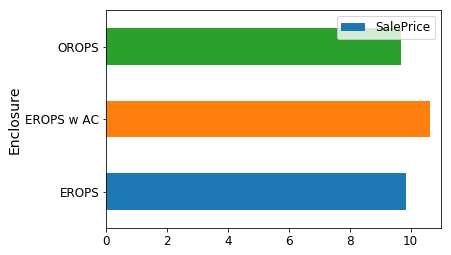

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

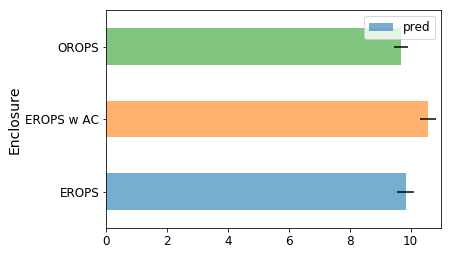

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

In [17]:
raw_valid.ProductSize.value_counts()

Large / Medium    1706
Medium            1549
Mini              1369
Small              624
Large              297
Compact            143
Name: ProductSize, dtype: int64

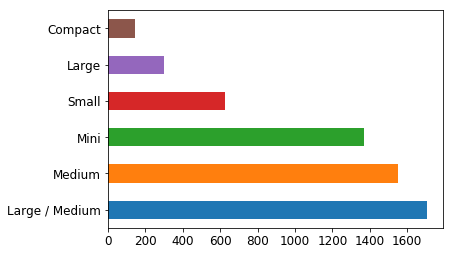

In [19]:
raw_valid.ProductSize.value_counts().plot.barh();

In [20]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.845075,0.335381
Large,10.470589,10.398313,0.362737
Large / Medium,10.691871,10.642867,0.291842
Medium,10.681511,10.616842,0.283865
Mini,9.535147,9.572816,0.265213
Small,10.324448,10.324261,0.290307


In [21]:
# Coefficient of Variation = Standard Deviation / Mean
(summ.pred_std/summ.pred).sort_values(ascending=False) 

ProductSize
Large             0.035724
Compact           0.034875
Small             0.030280
Large / Medium    0.027641
Medium            0.026427
Mini              0.026086
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.176746
37,Coupler_System,0.102985
13,ProductSize,0.094489
14,fiProductClassDesc,0.088219
39,Hydraulics_Flow,0.061702
2,ModelID,0.059413
63,saleElapsed,0.051284
10,fiSecondaryDesc,0.040837
19,Enclosure,0.035105
38,Grouser_Tracks,0.031137


In [22]:
??rf_feat_importance

#def rf_feat_importance(m, df):
#    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
#                       ).sort_values('imp', ascending=False)

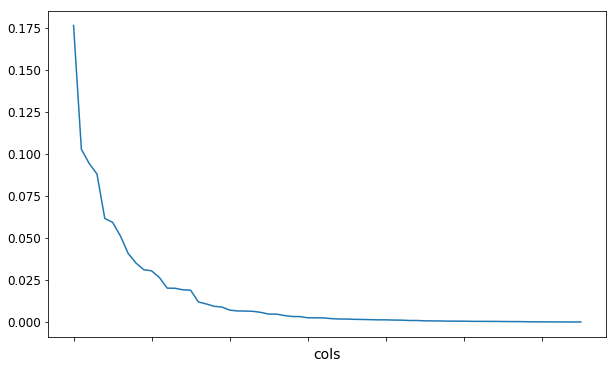

In [23]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [24]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

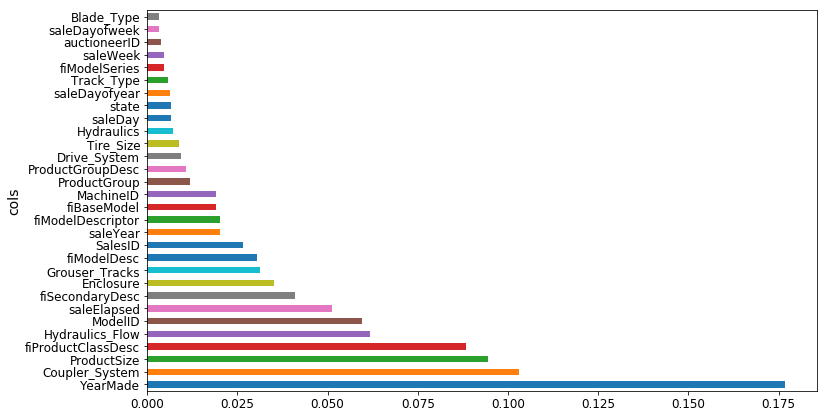

In [25]:
plot_fi(fi[:30]);

In [26]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [27]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn) # Use features only which importance are greater than 0.005

In [28]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20673412539982736, 0.24558398865666703, 0.9106778499512356, 0.8922919727958314, 0.8944145160745647]


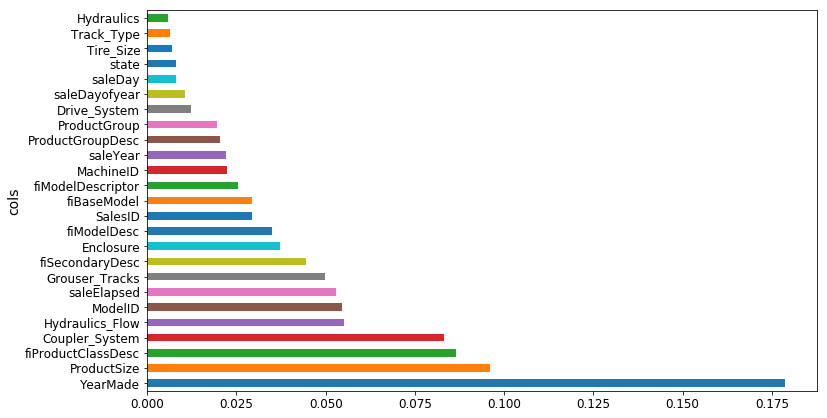

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

In [30]:
#  max_n_cat: The maximum number of categories to break into dummy values, instead of integer codes.
#  If col.nunique() < max_n_cat, apply one-hot encoding. Otherwise, apply integer encoding.

df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7) 
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20713851919423196, 0.25278411091135367, 0.9103280610455561, 0.88588374295409, 0.8926798239366494]


In [38]:
df_trn.head(3).T

,0,1,2
SalesID,1139246,1139248,1139249
MachineID,999089,117657,434808
ModelID,3157,77,7009
datasource,121,121,121
auctioneerID,3,3,3
YearMade,2004,1996,2001
MachineHoursCurrentMeter,68,4640,2838
UsageBand,3,3,1
fiModelDesc,950,1725,331
fiBaseModel,296,527,110


In [37]:
df_trn2.head(3).T

,0,1,2
SalesID,1139246,1139248,1139249
MachineID,999089,117657,434808
ModelID,3157,77,7009
datasource,121,121,121
auctioneerID,3,3,3
YearMade,2004,1996,2001
MachineHoursCurrentMeter,68,4640,2838
fiModelDesc,950,1725,331
fiBaseModel,296,527,110
fiSecondaryDesc,41,55,0


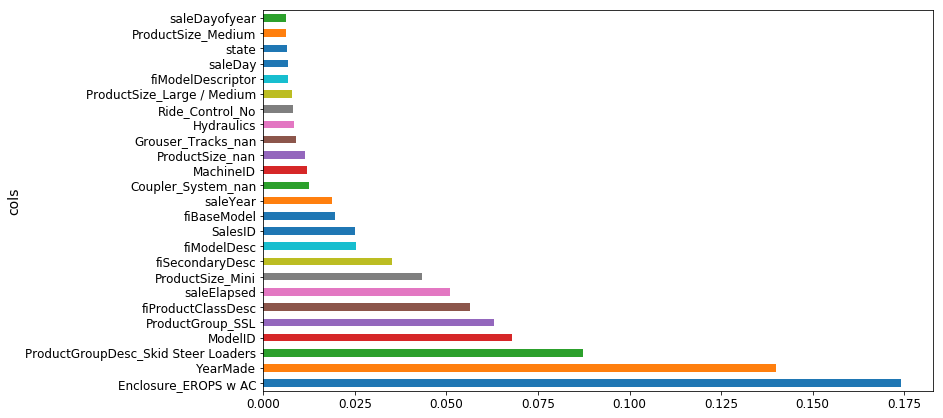

In [39]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [40]:
from scipy.cluster import hierarchy as hc

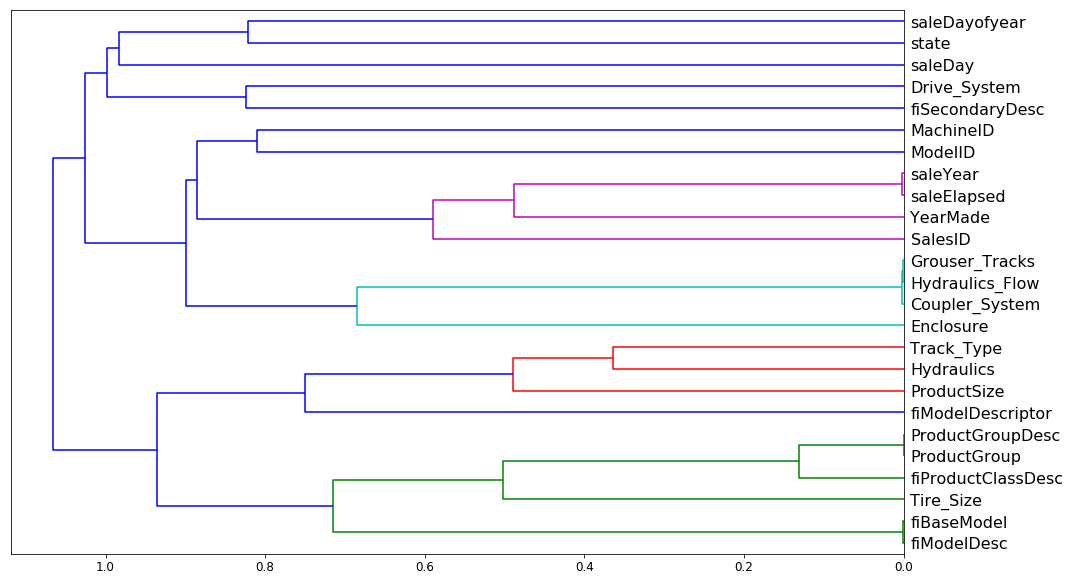

In [41]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [42]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [43]:
get_oob(df_keep)

0.8894921050539959

Now we try removing each variable one at a time.

In [44]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8897046139669663
saleElapsed 0.8870478639809474
fiModelDesc 0.8886585578597302
fiBaseModel 0.8895653121854247
Grouser_Tracks 0.8899665475783365
Coupler_System 0.890271062230266


It looks like we can try one from each group for removal. Let's see what that does.

In [45]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8889962687667039

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [46]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [47]:
df_keep.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'Hydraulics_Flow', 'ModelID', 'saleElapsed', 'fiSecondaryDesc',
       'Enclosure', 'fiModelDesc', 'SalesID', 'fiModelDescriptor', 'MachineID',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Tire_Size',
       'Hydraulics', 'saleDay', 'state', 'saleDayofyear', 'Track_Type'],
      dtype='object')

In [48]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [49]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [50]:
reset_rf_samples()

In [51]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12497361035703375, 0.2264940962281577, 0.9673583984804179, 0.9083860208949966, 0.9085231181335173]


# Partial dependence

In [52]:
from pdpbox import pdp
from plotnine import *

In [53]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [54]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

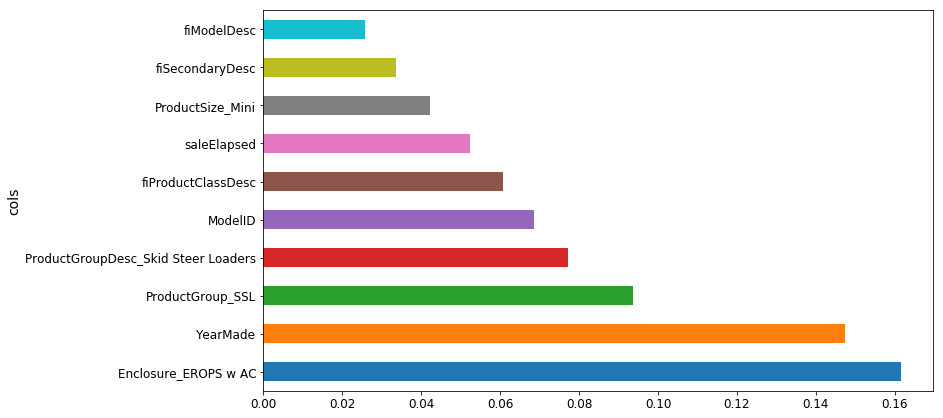

In [55]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

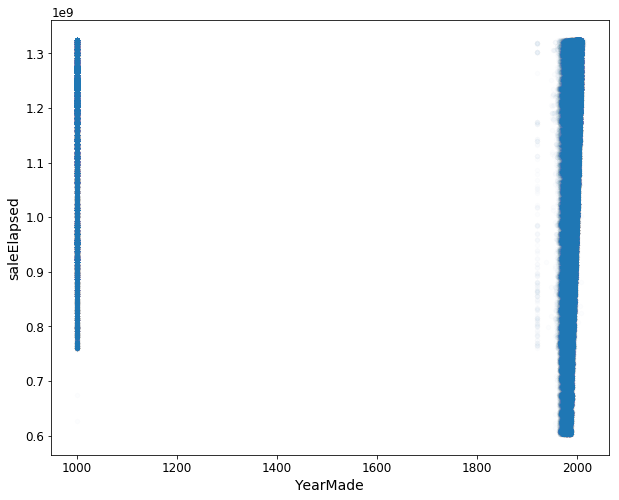

In [56]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [57]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

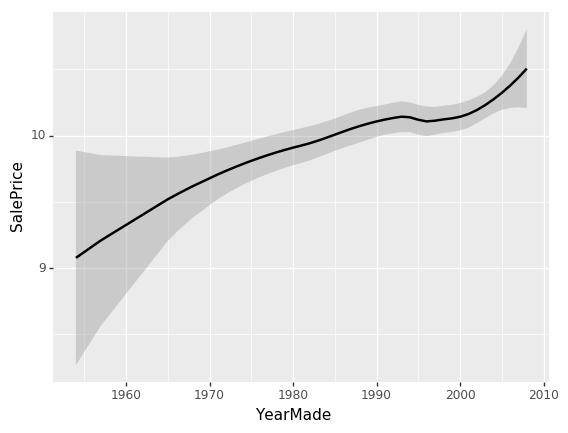

<ggplot: (7564977693)>

In [58]:
# You'll need to install skmisc by 'pip install scikit-misc'
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [59]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [60]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

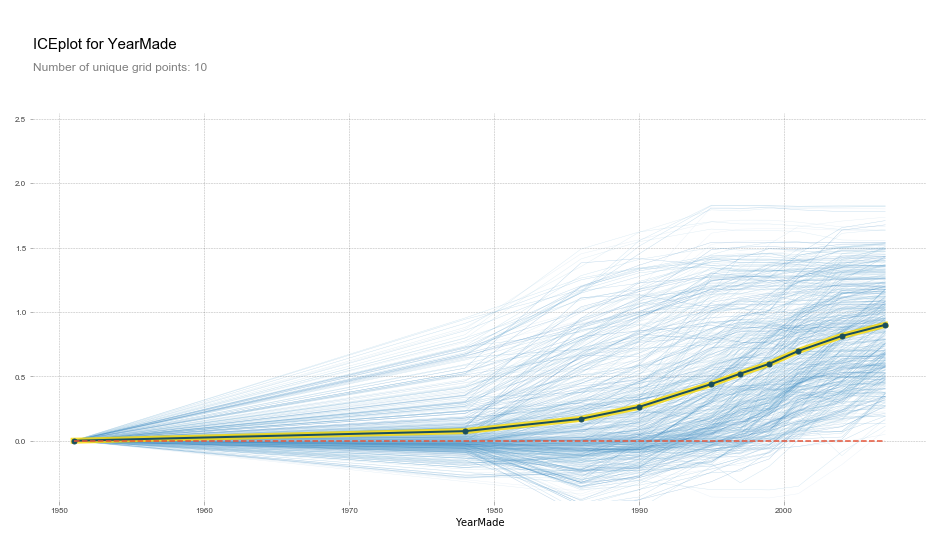

In [61]:
# ICE: Individual Conditional Expectation
plot_pdp('YearMade')

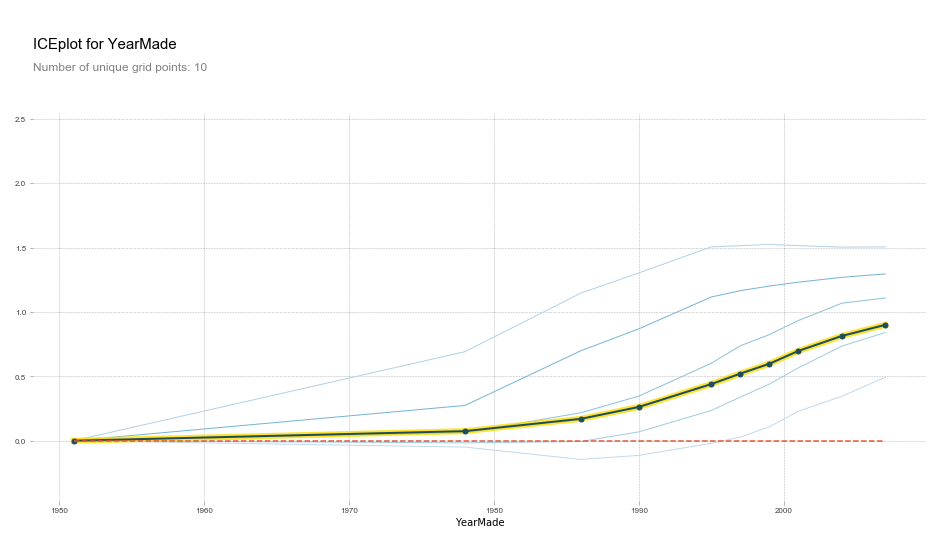

In [62]:
plot_pdp('YearMade', clusters=5)

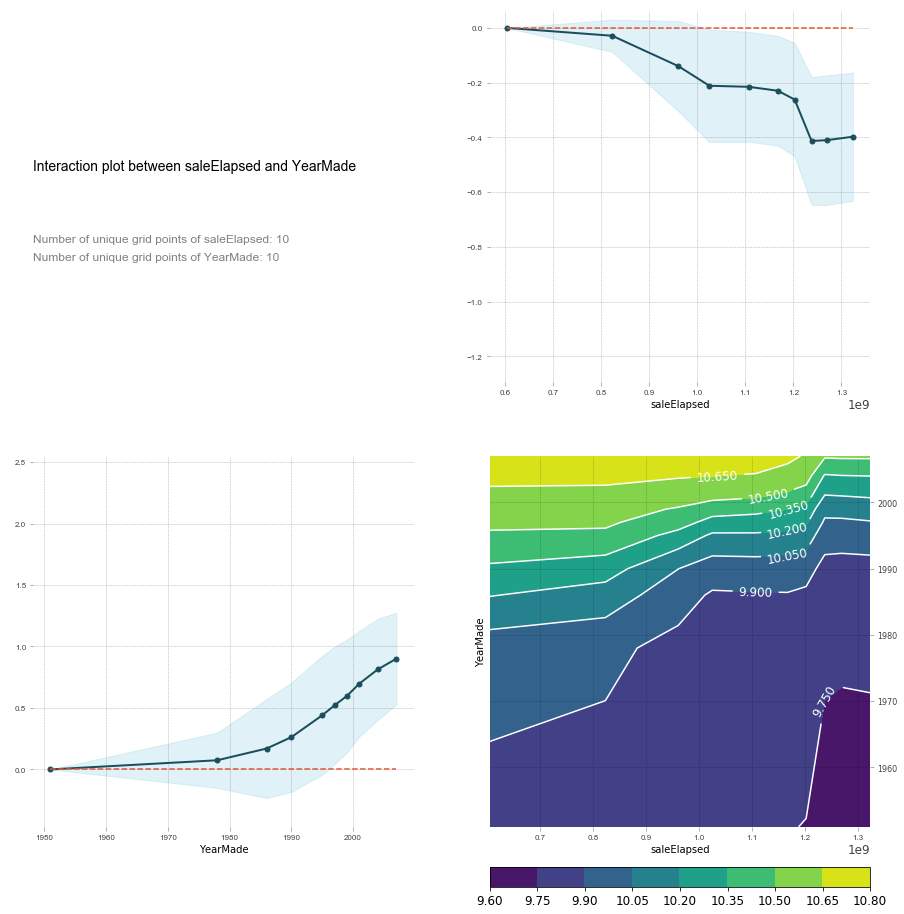

In [63]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

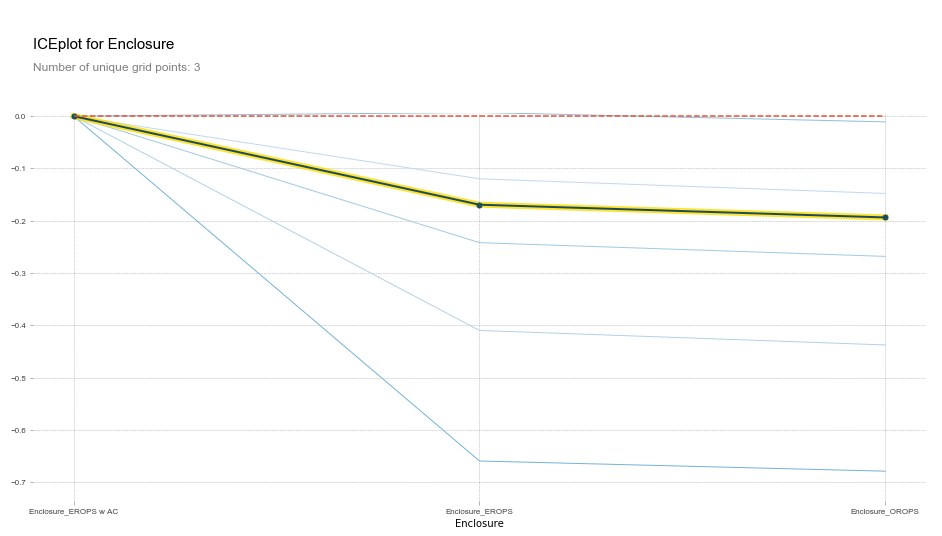

In [64]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [65]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950 # set 1950 if YearMade is less than 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade # create a new feature 

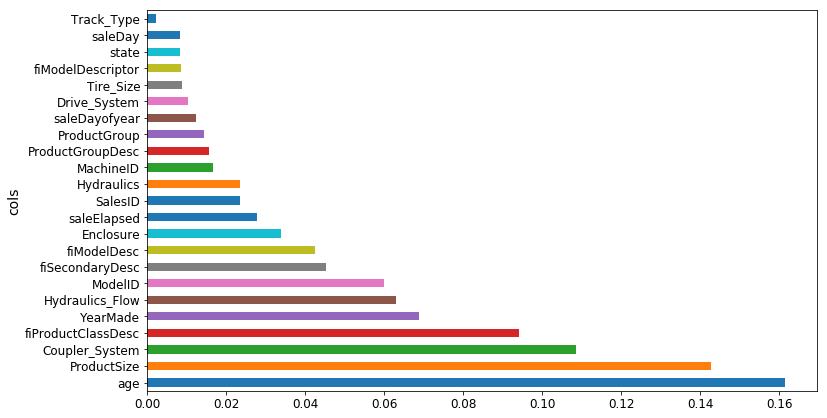

In [66]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [67]:
# You'll need to install treeinterpreter by 'pip install treeinterpreter'
from treeinterpreter import treeinterpreter as ti

In [68]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [69]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,          0,        665, 1284595200,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          4,          0,
                 0,         12,         16,         35,        259,          2,         11]])

In [70]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
prediction, bias, contributions = ti.predict(m, row)

In [72]:
prediction[0], bias[0]

(9.3488583946499, 10.10482367963202)

In [73]:
idxs = np.argsort(contributions[0])

In [74]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5318189801957858),
 ('age', 11, -0.12104571287295567),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1175619079992806),
 ('fiModelDesc', 'KX1212', -0.08916145448452228),
 ('fiSecondaryDesc', nan, -0.05897353104437446),
 ('Tire_Size', nan, -0.023366553065856666),
 ('saleDayofyear', 259, -0.021737388208441732),
 ('fiModelDescriptor', nan, -0.021386676674018768),
 ('saleDay', 16, -0.021160123764264505),
 ('SalesID', 4364751, -0.00973480642626412),
 ('Enclosure', 'EROPS', -0.008563375059639134),
 ('saleElapsed', 1284595200, -0.005343705012522371),
 ('ProductGroupDesc', 'Track Excavators', 0.0017062305784626198),
 ('Drive_System', nan, 0.0030874331905441643),
 ('Track_Type', 'Steel', 0.004912586782198236),
 ('state', 'Ohio', 0.0051498610787007685),
 ('Hydraulics', 'Standard', 0.008101925652549103),
 ('ProductGroup', 'TEX', 0.014264020953298217),
 ('MachineID', 2300944, 0.020841685379800357),
 ('Hydraulics_Flow', nan, 0.0289

In [75]:
contributions[0].sum()

-0.7559652849821192

# Extrapolation

In [76]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid') # dependency variable is 'is_valid' (first 'n_trn' data is 1)

In [77]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

In [78]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.859734
6,saleElapsed,0.091066
12,MachineID,0.040353
0,YearMade,0.002093
5,ModelID,0.001523
9,fiModelDesc,0.001297
20,saleDayofyear,0.001178
1,Coupler_System,0.000646
8,Enclosure,0.000332
4,Hydraulics_Flow,0.000331


In [79]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [80]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [81]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [82]:
x.drop(feats, axis=1, inplace=True)

In [83]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_ # oob score will drop from 0.999

0.9788993455905266

In [84]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.226509
0,YearMade,0.194321
17,saleDayofyear,0.157977
5,ModelID,0.074873
8,fiModelDesc,0.061237
15,saleDay,0.058958
16,state,0.054306
3,fiProductClassDesc,0.032597
6,fiSecondaryDesc,0.024999
7,Enclosure,0.021619


In [85]:
set_rf_samples(50000)

In [86]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [87]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2082810117642912, 0.24700006098772867, 0.909336144529639, 0.8910462719597607, 0.8928206409125372]


In [88]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2086312636122503, 0.24500529780724337, 0.9090309618064942, 0.8927989782705255, 0.8927901743696534]
saleElapsed
[0.21391195684981934, 0.2553501357231036, 0.904367623707619, 0.883555183712919, 0.8872542342190104]
MachineID
[0.2065960783034697, 0.2439495312700114, 0.9107971001864745, 0.8937208799507887, 0.8950431609311605]
age
[0.20874923485112892, 0.2497982236757981, 0.9089280552325167, 0.8885637047042159, 0.8923113663136832]
YearMade
[0.20885672769330169, 0.2514658905450224, 0.9088342383358512, 0.8870708281782194, 0.8922144280933819]
saleDayofyear
[0.2087113127553897, 0.2452248919079856, 0.9089611411052501, 0.8926067272314914, 0.8927802990497052]


In [89]:
reset_rf_samples()

In [90]:
# Score without ['SalesID', 'MachineID', 'saleDayofyear'] does not get worse much. So, we'll drop them.
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1) 
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13757153958100884, 0.2175597554962502, 0.9604458531852855, 0.915471123218809, 0.9092152177249146]


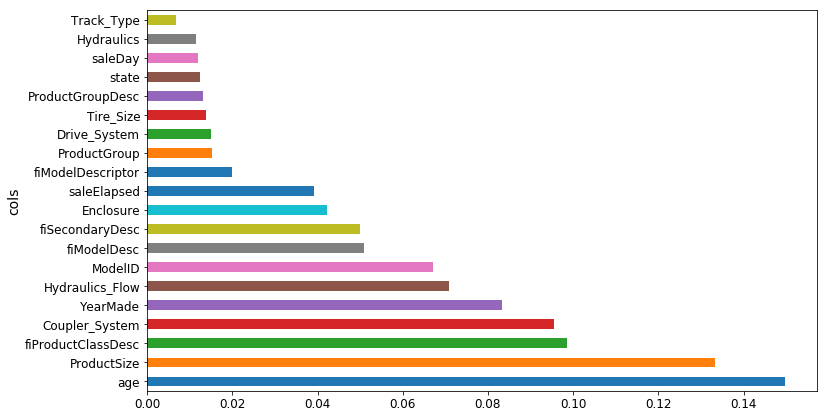

In [91]:
plot_fi(rf_feat_importance(m, X_train));

In [92]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [93]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min, sys: 9.8 s, total: 4min 9s
Wall time: 2min 4s
[0.0800746940077723, 0.21142027528454657, 0.9865993642796249, 0.9201745745436742, 0.9146021295637128]
